# Архитектура

Alternatively to the models by (Chung et al. 2015) and (Luo et al. 2018), we model a temporal dependency only in the prior distribution. Therefore, our model is similar to the deep Markov model by (Krishnan et al. 2017), but we do not use the Markov assumption.
By excluding the dependency from past realizations (the autoregressive part) for the observable returns R, the return distribution is independent from past returns but not from the past latent variables Z. Therefore, we force the encoder of the implemented model to encode as much information as possible in the latent variables Z. As a consequence, properties of conventional VAE such as the auto-pruning can be observed properly. This is not necessarily the case if we model the decoder distribution to be autoregressive on the returns R2, as assumed by (Luo et al. 2018) and (Chung et al. 2015). In this case, a substantial part of the information that can be used by the decoder would not have to pass the bottleneck. Even if the posterior q(Z|R) collapses and becomes independent of the input, the decoder would be able to use past observed R to achieve a good fit. By using the TempVAE for modeling the portfolio return, we can generate many realizations of the actual return (we use 1000 realizations) and then use the resulting empirical quantile of the loss function for the estimation of the VaR.
hzt and hrt are defined as the hidden states of the RNNs, propagating past information through later time points. The initial states are set to zero. Combining the hidden states of the model is possible and yields a more general model formulation. However, during our experiments, it turned out to be favorable to use not trainable priors
When using the TempVAE on financial data, we observe an instantaneous collapse of the posterior at the beginning of the training. From our point of view, the signal within the financial returns data is not strong enough to be captured before the KL-Divergence term dominates the ELBO and causes a posterior collapse. Therefore, we consider β-annealing of the KL-Divergence
For the RNNs, we choose ‘Gated Recurrent Units’ (see Cho et al. 2014) with dimension 16, and the initial values of these states are set to zero. For the MLPs, we use normal Feedforward Networks that have two hidden layers with dimension 16 and the output layer with varying output dimension. For the latent variables, we choose dimension 10. We initialize all MLP layer weights with the ‘Variance Scaling’ initializer as proposed by He et al. (2015). As the activation function for the hidden layers, we use the ‘Rec- tified Linear Unit’ (ReLU). For the μz, μˆz and μr layer, we use no activation. We use a diagonal covariance structure for Σz and Σˆ z and a rank-1 perturbation output as given in Rezende et al. (2014) for Σr. For all covariance layers, we use exponential activation for the diagonal entries. Furthermore, we add L2 regularization with parameter λ = 0.01 for the weights of the hidden layers of the MLP as well as dropout with a rate of 10% to the RNN layers.


In [79]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
!git clone https://github.com/lqwic/deep_var.git
%cd deep_var/

Cloning into 'deep_var'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 47 (delta 9), reused 15 (delta 5), pack-reused 25
Receiving objects: 100% (47/47), 23.28 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/deep_var/deep_var


In [190]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

stocks = load_data(data_path + 'stocks.csv')
commodities = load_data(data_path + 'commodities.csv')
crypto = load_data(data_path + 'cryptos.csv')

window_size = 21
alpha = 99
train_size = 0.8
data = crypto

In [82]:
split_index = int(len(data) * train_size)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index - window_size:]

# Model

In [314]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.1):
        super(EncoderRNN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout_rate)
        )
        self.rnn = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc_mean = nn.Linear(2 * hidden_size, latent_size)
        self.fc_logvar = nn.Linear(2 * hidden_size, latent_size)

    def forward(self, x):
        x = self.mlp(x)
        _, h_n = self.rnn(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)  # Concatenate forward and backward hidden states
        mean = self.fc_mean(h_n)
        logvar = self.fc_logvar(h_n)
        return mean, logvar

class DecoderRNN(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, dropout_rate=0.1):
        super(DecoderRNN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout_rate)
        )
        self.rnn = nn.GRU(input_size=latent_size, hidden_size=hidden_size, batch_first=True)
        # self.rnn = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            # nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, z):
        # z = self.mlp(z)
        output, _ = self.rnn(z)
        output = self.fc(output)
        return output

In [315]:
class TempVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers=1):
        super(TempVAE, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, latent_size, num_layers)
        self.decoder = DecoderRNN(latent_size, hidden_size, input_size, num_layers)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        recon_x = self.decoder(z)
        return recon_x, mean, log_var

    def loss_function(self, recon_x, x, mean, log_var, beta, lambda_reg):
        recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        l2_loss = sum(p.pow(2).sum() for p in self.parameters())
        loss = recon_loss + beta * kl_loss + lambda_reg * l2_loss
        return loss

Since we assume a Gaussian distribution for q and p, we can analytically calculate the Kullback-Leibler divergence (KL-Divergence) inside the expectation in (20). We approxi- mate the outer expectations numerically by Monte Carlo.

In [275]:
from torch.utils.data import TensorDataset, DataLoader

def preprocess_data(train_data, test_data, window_size, batch_size):
    train_tensors = torch.tensor(train_data.values, dtype=torch.float32)
    test_tensors = torch.tensor(test_data.values, dtype=torch.float32)
    train_dataset = TensorDataset(train_tensors)
    test_dataset = TensorDataset(test_tensors)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [303]:
def train_temporal_vae(model, data, epochs, batch_size, learning_rate):
    window_size = 21
    T = window_size - 1

    split_index = int(len(data) * 0.8)
    train_data = data[:split_index]
    test_data = data[split_index - window_size:]

    num_samples_train, feature_size = train_data.shape
    num_samples_test = test_data.shape[0]

    beta_start = 0.0
    beta_end = 1.0
    beta_threshold = 200
    lambda_reg = 0.001

    initial_learning_rate = learning_rate

    inputs_train = []
    targets_train = []
    for i in range(num_samples_train - window_size + 1):
        inputs_train.append(train_data[i:i+T])
        targets_train.append(train_data[i+T])

    inputs_train = torch.tensor(inputs_train, dtype=torch.float32)
    targets_train = torch.tensor(targets_train, dtype=torch.float32)

    dataset_train = TensorDataset(inputs_train, targets_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

    inputs_test = []
    targets_test = []
    for i in range(num_samples_test - window_size + 1):
        inputs_test.append(test_data[i:i+T])
        targets_test.append(test_data[i+T])

    inputs_test = torch.tensor(inputs_test, dtype=torch.float32)
    targets_test = torch.tensor(targets_test, dtype=torch.float32)

    dataset_test = TensorDataset(inputs_test, targets_test)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in trange(epochs):
        total_loss = 0
        if epoch < beta_threshold:
            beta = beta_start
        else:
            beta = beta_start + (beta_end - beta_start) * (epoch - beta_threshold) / (epochs - beta_threshold)
        for batch_idx, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()
            pred_y, mean, logvar = model(x)
            loss = model.loss_function(pred_y, y, mean, logvar, beta, lambda_reg)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                pred_y, mean, logvar = model(next(iter(dataloader_test))[0].to(device))
                test_loss = model.loss_function(pred_y, next(iter(dataloader_test))[1].to(device), mean, logvar, beta, lambda_reg)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f"tempvae_epoch_{epoch+1}.pth"))

            decay_rate = 0.96
            decay_steps = 20
            lr = initial_learning_rate * (decay_rate ** (epoch // decay_steps))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr


In [316]:
import os
save_dir = "saved_models/"

epochs = 1000
batch_size = 256
learning_rate = 0.001

input_size = data.shape[1]
hidden_size = 16
latent_size = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TempVAE(input_size, hidden_size, latent_size).to(device)
train_loader, test_loader = preprocess_data(train_data, test_data, window_size, batch_size)

train_temporal_vae(model, data.values, epochs, batch_size, learning_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 11.0755, Test Loss: 12.0220
Epoch [20/1000], Train Loss: 5.9717, Test Loss: 5.2723
Epoch [30/1000], Train Loss: 5.6018, Test Loss: 4.9160
Epoch [40/1000], Train Loss: 5.4891, Test Loss: 4.7827


KeyboardInterrupt: 

In [326]:
model = TempVAE(input_size, hidden_size, latent_size).to(device)
model.load_state_dict(torch.load('saved_models/tempvae_epoch_20.pth'))

<All keys matched successfully>

In [349]:
num_features = test_data.shape[1]
window_size = 21
x_random = torch.rand(window_size, num_features).to(device)

x_random = x_random.unsqueeze(0)
mu, logvar = model.encoder(x_random)
print("Mean:", mu)
print("Logvar:", logvar)

z_sample = model.reparameterize(mu, logvar)
print("Z Sample:", z_sample)
x_hat_sample = model.decoder(z_sample)
print("Reconstructed X Sample:", x_hat_sample)

Mean: tensor([[-0.7245,  0.3375, -0.3085, -1.1882, -0.8142, -1.0438, -1.0492, -1.1834,
          0.5797, -0.7762]], grad_fn=<AddmmBackward0>)
Logvar: tensor([[-1.7902, -2.3931, -2.0000, -2.4504, -2.7174, -2.2011, -2.5374, -2.8362,
         -2.9659, -1.7224]], grad_fn=<AddmmBackward0>)
Z Sample: tensor([[-1.3252,  0.0433, -0.3266, -0.8995, -0.6078, -1.1692, -1.2520, -1.1986,
          0.8105, -0.9042]], grad_fn=<AddBackward0>)
Reconstructed X Sample: tensor([[ 0.0265,  0.0433, -0.0272,  0.0340,  0.0189, -0.0831, -0.0282,  0.1134,
         -0.0713, -0.0410, -0.0225,  0.0319,  0.0747]],
       grad_fn=<AddmmBackward0>)


In [328]:
num_columns = test_data.shape[1]
random_weights = np.random.rand(num_columns)
normalized_weights = random_weights / np.sum(random_weights)

vars = []
preds = []
window_size = 21

device = next(model.parameters()).device
model.eval()

for i in trange(len(test_data) - window_size):
    x = torch.tensor(test_data.values[i:i + window_size], dtype=torch.float32).to(device)
    x = x.unsqueeze(0)
    samples = []
    for _ in range(1000):
        with torch.no_grad():
            mu, logvar = model.encoder(x)
            z_sample = model.reparameterize(mu, logvar)
            x_hat_sample = model.decoder(z_sample)
            x_hat_sample = x_hat_sample.squeeze(0).cpu().numpy()
            portfolio_value = np.dot(x_hat_sample, normalized_weights)
            samples.append(portfolio_value)
    var = np.percentile(samples, 1)
    pred = np.mean(samples)
    preds.append(pred)
    vars.append(var)

  0%|          | 0/439 [00:00<?, ?it/s]

KeyboardInterrupt: 

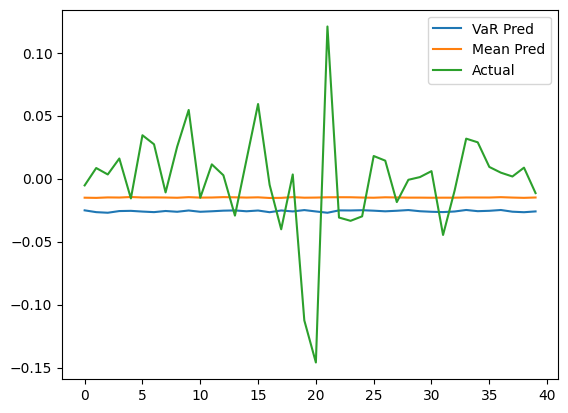

In [329]:
plt.plot(vars, label='VaR Pred')
plt.plot(preds, label='Mean Pred')
plt.plot(np.dot(test_data[window_size: len(vars) + window_size].values, normalized_weights), label='Actual')
plt.legend()
plt.show()